In [175]:
import os
import folium
import numpy as np
import pandas as pd
import pyproj as pj
import math
from folium.plugins import HeatMap
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# gps.csv contains five features: user_id, record_time, latitude, longitude, accu
gps_df = pd.read_csv("gps.csv")

In [16]:
# battery.csv contains two features: user_id, record_time
battery_df = pd.read_csv("battery.csv")

In [4]:
# latitude and longitude of saskatoon center
lat_center_saskatoon = (52.058367 + 52.214608) / 2
lon_center_saskatoon = (-106.7649138128 - 106.52225318) / 2

In [5]:
# render unfiltered gps data. You can open this heatmap by firefox
m1 = folium.Map([lat_center_saskatoon, lon_center_saskatoon], tiles='stamentoner', zoom_start=6)
HeatMap(gps_df[['lat', 'lon']].values.tolist()).add_to(m1)
m1.save(os.path.join('.', 'unfiltered_heatmap.html'))

In [28]:
# calculate number of total possible battery records per particiants
battery_df.record_time = battery_df.record_time.astype('datetime64')
time_interval = battery_df.record_time.max() - battery_df.record_time.min()
num_total_possible_records = np.ceil(time_interval.total_seconds() / 300)

In [34]:
# calculate the number of all battery records per user.
battery_counts_df = battery_df.groupby(['user_id']).size().reset_index(name='counts')
battery_counts_df.describe()

,user_id,counts
count,108.000000,108.000000
mean,1084.518519,3276.287037
std,274.204286,2718.917432
min,264.000000,1.000000
25%,939.750000,646.750000
50%,1077.500000,2233.000000
75%,1315.250000,6155.750000
max,1364.000000,7655.000000


We have 108 participants having battery records in total.

In [68]:
# filter battery dataframe in 50% threshold
fifty_user_df = battery_counts_df[battery_counts_df.counts >= num_total_possible_records * 0.5]
fifty_user_df.count()

user_id    43
counts     43
dtype: int64

There are 43 participants having more than 50% of total possible battery records. So we remove 65 participants.

In [69]:
# filter battery dataframe in 75% threshold
seventyfive_user_df = battery_counts_df[battery_counts_df.counts >= num_total_possible_records * 0.75]
seventyfive_user_df.count()

user_id    26
counts     26
dtype: int64

There are 26 participants having more than 75% of total possible battery records. So we remove 82 participants.

In [42]:
# convert the datatype of record_time from object to datatime64
gps_df.record_time = gps_df.record_time.astype('datetime64')

In [45]:
# count total number of gps records
gps_df.count()

user_id        8592409
record_time    8592409
accu           8592409
lat            8592409
lon            8592409
dtype: int64

We have 8592409 gps records in total.

In [80]:
# filter gps records in Greater Saskatoon and having an accuracy less than 100m
valid_gps_df = gps_df[(gps_df.lat <= 52.214608) & (gps_df.lat >= 52.058367) & (gps_df.lon <= -106.52225318) & (gps_df.lon >= -106.7649138128) & (gps_df.accu <= 100)]

In [81]:
valid_gps_df.count()

user_id        7956573
record_time    7956573
accu           7956573
lat            7956573
lon            7956573
dtype: int64

We have 7956573 valid records. And "valid" means that gps locations are inside the city limits of Greater Saskatoon and having accuracies better than 100m. So we remove 635836 gps records.

In [71]:
# filter gps records in Greater Saskatoon, having an accuracy less than 100m, and in 50% threshold of battery records
gps_df[gps_df.user_id.isin(fifty_user_df.user_id.values.tolist())].count()

user_id        6104617
record_time    6104617
accu           6104617
lat            6104617
lon            6104617
dtype: int64

We have 6104617 gps records for participants who having 50% of total possible battery records. In this filtering case, we remove 2487792 gps records.

In [73]:
# filter gps records in Greater Saskatoon, having an accuracy less than 100m, and in 75% threshold of battery records
gps_df[gps_df.user_id.isin(seventyfive_user_df.user_id.values.tolist())].count()

user_id        4261446
record_time    4261446
accu           4261446
lat            4261446
lon            4261446
dtype: int64

We have 4261446 gps records for participants who having 50% of total possible battery records. In this filtering case, we remove 4330963 gps records.

## Summary
* We remove 65 participants in 50% threshold
* We remove 82 participants in 75% threshold

| Case | number of GPS records removed |
| ---- | ----------------------------- |
| 50% threshold | 2487792 |
| 75% threshold | 4330963 |
| In Greater Saskatoon and accuracy less than 100m | 635836 |

Next, we create a dataframe containing only the 50% or better participants, Saskatoon location, and accuracy less than 100m gps data for further analysis.

In [88]:
analysis_gps_df = gps_df[(gps_df.lat <= 52.214608) & (gps_df.lat >= 52.058367) & (gps_df.lon <= -106.52225318) & (gps_df.lon >= -106.7649138128) & (gps_df.accu <= 100) & (gps_df.user_id.isin(fifty_user_df.user_id.values.tolist()))]

In [94]:
# save the gps records that we will analyze into csv file
analysis_gps_df.to_csv('analysis_gps.csv', index=False)

In [3]:
analysis_gps_df = pd.read_csv("analysis_gps.csv")

In [5]:
# render filtered gps data. You can open this heatmap by firefox
m2 = folium.Map([lat_center_saskatoon, lon_center_saskatoon], tiles='stamentoner', zoom_start=6)
HeatMap(analysis_gps_df[['lat', 'lon']].values.tolist()).add_to(m2)
m2.save(os.path.join('.', 'filtered_heatmap.html'))

In [10]:
# convert the datatype of record_time from object to datatime64
analysis_gps_df.record_time = analysis_gps_df.record_time.astype('datetime64')
# calculate the minimum timestamp of all records
min_timestamp = analysis_gps_df.record_time.min()

In [11]:
# convert record_time to relative_time by duty cycle
analysis_gps_df.loc[:, 'relative_time'] = np.floor((analysis_gps_df.record_time - min_timestamp).dt.total_seconds() / 300).astype('int')

In [12]:
# We don't need the 'accu' column in further analysis
analysis_gps_df = analysis_gps_df.drop(columns=['accu'])

In [13]:
# group the dataframe by user_id, and relative_time, then calculate the average latitude and longitude coordinates
analysis_gps_df_aggregated = analysis_gps_df.groupby(['user_id', 'relative_time'], as_index=False).mean()

In [14]:
# transfer latitude and longitude coordinates to UTM coordinates
p1 = pj.Proj(init='epsg:32613')
x, y = p1(analysis_gps_df_aggregated.lon.values.tolist(), analysis_gps_df_aggregated.lat.values.tolist())
analysis_gps_df_aggregated.loc[:, 'x'] = x
analysis_gps_df_aggregated.loc[:, 'y'] = y

In [16]:
# drop lat and lon columns, we don't need that
analysis_gps_df_aggregated = analysis_gps_df_aggregated.drop(columns=['lat', 'lon'])

In [18]:
# save gps records in UTM coordinates into csv file
analysis_gps_df_aggregated.to_csv('aggregated_x_y_location.csv', index=False)

In [286]:
# calculate the start and end coordinates in UTM for the greater Saskatoon area
start_x, start_y = p1(-106.7649138128, 52.058367)
end_x, end_y = p1(-106.52225318, 52.214608)

In [287]:
# convert UTM coordinates into grid coordinates
def which_grid(x, y, start_x, start_y, step):
    which_grid_x = np.floor((x - start_x) / step)
    which_grid_y = np.floor((y - start_y) / step)
    
    # in case UTM coordinates in the boundary of the greater Saskatoon area
    # there are some -1 value appearing
    # set all -1 to 0
    which_grid_x[which_grid_x < 0] = 0
    which_grid_y[which_grid_y < 0] = 0
    
    return(which_grid_x, which_grid_y)

In [299]:
def operationalize(file_path, lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, step):
    # load the data we want to operationalize
    df = pd.read_csv(file_path)
    
    # convert UTM coordinates into grid coordinates
    df.loc[:, 'grid_x'], df.loc[:, 'grid_y'] = which_grid(df.x.values, df.y.values, start_x, start_y, step)
    df = df.drop(columns=['x', 'y'])
    
    #convert datatype from float64 to int
    df.grid_x = df.grid_x.astype('int')
    df.grid_y = df.grid_y.astype('int')
    
    # Calculate dwell time
    temp = df
    temp = temp.sort_values(by=['user_id', 'relative_time'])
    temp.loc[:, 'shift_grid_x'] = shift(temp.grid_x, -1, cval=0)
    temp.loc[:, 'shift_grid_y'] = shift(temp.grid_y, -1, cval=0)
    temp.loc[:, 'dwell_time'] = ((temp.grid_x != temp.shift_grid_x) | (temp.grid_y != temp.shift_grid_y))
    temp.dwell_time = temp.dwell_time.astype('int')
    temp.dwell_time = temp.dwell_time.cumsum()
    value_count = temp.groupby(['dwell_time']).size().reset_index(name='counts')
    counts_of_counts = value_count.groupby(['counts']).size().reset_index(name='num_of_counts')
    dt = counts_of_counts[['counts', 'num_of_counts']].values
    
    # Calculate visit frequency
    df_groupby_xy = df.groupby(['user_id', 'grid_x', 'grid_y'], as_index=False).count()
    visit_frequency = dict(Counter(df_groupby_xy.relative_time))
    lists = sorted(visit_frequency.items())
    vf = np.column_stack(zip(*lists))
    
    # Convert grid coordinates back to lat and lon coordinates
    temp_x = (df.grid_x + 0.5) * step + start_x
    temp_y = (df.grid_y + 0.5) * step + start_y
    temp_x[temp_x > end_x] = end_x
    temp_y[temp_y > end_y] = end_y
    df.loc[:, 'center_lon'], df.loc[:, 'center_lat'] = p1(temp_x.tolist(), temp_y.tolist(), inverse=True)
    m = folium.Map([lat_center_saskatoon, lon_center_saskatoon], tiles='stamentoner', zoom_start=6)
    # render the heatmap
    HeatMap(df[['center_lat', 'center_lon']].values.tolist()).add_to(m)
    filename = "step_" + str(step) + "_heatmap.html"
    m.save(os.path.join('.', filename))
    
    return (vf, dt)

In [300]:
vf_100, dt_100 = operationalize('aggregated_x_y_location.csv', lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, 100)

In [301]:
vf_400, dt_400 = operationalize('aggregated_x_y_location.csv', lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, 400)

In [302]:
vf_1600, dt_1600 = operationalize('aggregated_x_y_location.csv', lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, 1600)

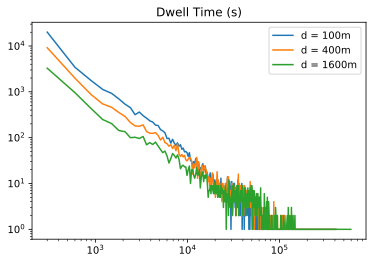

In [308]:
plt.loglog(dt_100[:,0] * 5 * 60, dt_100[:,1])
plt.loglog(dt_400[:,0] * 5 * 60, dt_400[:,1])
plt.loglog(dt_1600[:,0] * 5 * 60, dt_1600[:,1])
plt.legend(["d = 100m", "d = 400m", "d = 1600m"])
plt.title("Dwell Time (s)")
plt.savefig("dwell_time.pdf", bbox_inches='tight')
plt.show()

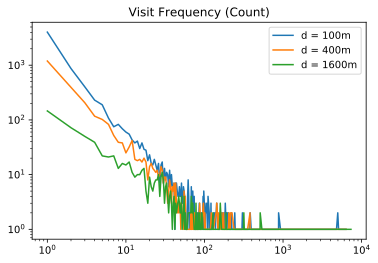

In [309]:
plt.loglog(vf_100[:,0], vf_100[:,1])
plt.loglog(vf_400[:,0], vf_400[:,1])
plt.loglog(vf_1600[:,0], vf_1600[:,1])
plt.legend(["d = 100m", "d = 400m", "d = 1600m"])
plt.title("Visit Frequency (Count)")
plt.savefig("visit_frequency.pdf", bbox_inches='tight')
plt.show()